# Molecular Dynamics Asignment: Barrier Crossing

### Intended learning outcomes
1. The effects on the time step on the total energy fluctuations
2. Transformation of energy (potential vs kinetic energy)
3. Concept of phase space and available microstates in different ensembles
4. Sampling differences between MD and MC


Consider the movement of a single particle that moves on a 1D potential energy surface with the following functional form:
$$
U(x)=
\begin{cases}
\epsilon B x^2, & \text{if}\ x \leq 0.0\\
\epsilon \left( 1 - \cos(2\pi x)\right), & \text{if}\ 0.0 < x < 1.0\\
\epsilon B (1-x^2), & \text{if}\ x \geq 1.0
\end{cases}
\tag{eq. 1}
$$
The energy, force and the derivative of the force should be continuous functions of the position $x$ and $\epsilon$ > 0. We want to investigate this system using Molecular dynamics.

**Question 1: Briefly explain Molecular dynamics (include the concepts Newton's equations of motion, trajectory, integrators, time step, ensembles, energy)**

In order to propagate positions and velocities in time, we need information about the acceleration, which is obtained from the forces. To make sure that our system is stable and can be integrated correctly, we need to make the potential, the force, and the derivative of the force (with respect to x) continuous. 

**Question 2: Derive an expression for $B$ so that the potential, force and derivative of the force becomes continuous and plot/sketch the energy landscape.**

Below a program is provided that integrates the equation of motion of the particle on the potential energy surface, starting at $x(t=0)=0$ using either molecular dynamics and methods thereof (case 1-3) or Monte Carlo simulation (case 4). 

<ul style="list-style-type:none;">
  <li>Case 1: Molecular dynamics, NVE ensemble</li>
  <li>Case 2: Molecular dynamics with Andersen thermostat</li>
  <li>Case 3: Molecular dynamics with Berendsen thermostat</li>
  <li>Case 4: Monte Carlo </li>
</ul> 

In case 2 and 3, we are approximating the NVT ensemble using two different thermostats.

Before conducting simulations, review the code and try to understand what is happening. In this lab exercise, we will only be using the Andersen thermostat to simulate the $NVT$ ensemble.

**Question 3: Conduct short simulations of the NVE ensemble using different time steps and comment on the differences in energy profiles (potential, kinetic and total energy). Elaborate on the differences you observe!**

Newton's equations tells us that if we have a set of particle positions and particle velocities at an arbitrary time, it is possible to predict the positions and velocities at any one particular instant in time. Therefore, classical dynamics of a $N$-particle system can be expressed by specifying the full set of 6$N$ functions ($2N$ for each dimension). The $6N$ numbers can be regarded as a single point in a $6N$-dimensional space named the _phase space_. The phase space is a Cartesian space and solving Newton's equations yields $6N$ tubles at different times which is considered a trajectory in phase space. Consequently, classical motion can be described by the motion of a point along a trajetory in phase space, with each point in phase space representing a possible microstate. 

**Question 4: What do you expect the phase space trajectories for the 1 particle to look like in terms of density and shape for the following situations, given a (i) Harmonic potential and (ii) the potential given in Eq. 1? _Hint_: The first term in Eq. 1 is a harmonic oscillator**
1. *NVE* ensemble 
2. *NVT* ensemble 



**Question 5: Using all the methods for a low temperature (150 < T < 300 K), comment on the following:**
1. Does the result correspond with what you expected in terms of the density and shape? Comment on any differences. 
2. Why does the phase space distribution of the MC scheme look so much different at low temperatures?
3. Why does the phase space distribution for the *NVE* and *NVT* ensemble look so different?
4. Show the configurational and kinetic partition function for the harmonic oscilator can be fitted to the MD data obtained using the Andersen thermostat using the code provided below.

**Question 6: Make a prediction at which starting temperature in the NVE ensemble the particle is able to cross the energy barrier and confirm using molecular dynamics. Base your prediction on the analytical expression given for the potential, but remember that velocities are distributed around the mean value.**

In [2]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import brewer2mpl
bmap = brewer2mpl.get_map('Set2','qualitative',8,reverse=True)
colors = bmap.mpl_colors
import random

In [76]:
# SIMULATION SETTINGS
eps = 15.0                                        # [kJ/(mol*nm**2)]
x_start = 0                                       # [nm]
Tstep = 0.01                                      # [ps]
Temperature = 11000                               # [K]
kB = 0.00831446                                   # [Dalton*nm**2 /(K*ps**2) = kJ/(mol*K)]
m = 1                                             # [Dalton]
Nstep = 100000
MU = 10                                           # [1/ps]
Coupling = Tstep                                  # [ps]
dp = 2.0                                          # [nm]
Nparticles = 50                                 # Number of independent particles

case = 1                                    # 1: NVE, 2: NVT (Andersen), 3: NVT (Berendsen), 4: NVT (Monte Carlo)

# LISTS FOR DATA COLLECTION
Data_pos  = np.empty(shape=(Nstep,Nparticles))
Data_vel  = np.empty(shape=(Nstep,Nparticles))
Data_time = np.empty(shape=Nstep)
Data_step = np.empty(shape=Nstep)
Data_Epot = np.empty(shape=(Nstep,Nparticles))
Data_Ekin = np.empty(shape=(Nstep,Nparticles))
Data_Etot = np.empty(shape=(Nstep,Nparticles))
Data_Temp = np.empty(shape=Nstep)

In [77]:
# FUNCTIONS FOR THE MOLECULAR DYNAMICS PROGRAM
def Potential(x):
    '''Function returning energy and force depending on the position, x, on the 1D energy surface.'''
    if x <= 0.0:
        U = eps *  2.0 * np.pi**2 * x**2
        F = eps * -4.0 * np.pi**2 * x
    elif x >= 1.0:
        U = eps * 2.0 * np.pi**2 * (x-1.0)**2
        F = eps * -4.0 * np.pi**2 * (x-1.0)
    else:
        U = eps * (1.0 - np.cos(2*np.pi*x))
        F = eps * -2.0 * np.pi * np.sin(2.0*np.pi*x)
    return U, F      
        
def VelocityVerlet_NVE(Position, Velocity, Force):
    '''Velocity Verlet algorithm using half step with no thermostat (NVE).'''
    Velocity += 0.5*Tstep*Force/m                 # [nm/ps]
    Position += Tstep*Velocity                    # [nm]
    U, F = Potential(Position)                    # [kJ/mol], [kJ/(nm*mol)]=[Dalton*nm/ps**2]
    Velocity += 0.5*Tstep*F/m                     # [nm/ps]
    
    return Position, Velocity, U, F

def Thermostat_And(Velocity):
    '''Andersen thermostat (NVT).'''
    random_particles = random.sample(range(Nparticles), int(np.random.randint(1, Nparticles-1, 1)))
    
    for particle in random_particles:
        # Check for stochastic collision
        if MU * Tstep > np.random.uniform(0,1):
            Velocity[particle] = RandomVelocity(Temperature,m)  # [nm/ps]
        
    return Velocity

def Thermostat_Ber(Velocity):
    ''''Berendsen thermostat (NVT).'''
    TInstant = m/kB*np.mean(Velocity**2)   # [K]
    Lambda = np.sqrt(1+Tstep/Coupling*((Temperature/TInstant)-1))
    Velocity *= Lambda    # [nm/ps]
    return Velocity

def MonteCarlo(Position, Accept):
    '''Monte Carlo simulation (NVT).'''
    Uold, Fold = Potential(Position)
    Position_new = Position + (np.random.uniform(0.0, 1.0) - 0.5) * dp 
    Unew, Fnew = Potential(Position_new)
    
    # Metropolis Criteria
    if np.exp(-(Unew-Uold)/(kB*Temperature)) >= np.random.uniform(0.0, 1.0):
        Position = Position_new
        Uold = Unew
        Accept+=1.0
    
    return Position, Uold, Accept

def RandomVelocity(Temperature, m):
    '''Random velocity asignment from the Maxwell-Boltzmann distribution.'''
    return np.sqrt(kB*Temperature/m) * np.random.normal(0,1,1)

def SampleData(Position, Velocity, i):
    '''Collection of data after each MD/MC itteration.'''
    Data_pos[i] = Position                          # [nm]
    Data_vel[i] = Velocity                          # [nm/ps]
    Data_time[i] = i*Tstep                          # [ps]
    Data_step[i] = i                                # Unitless
    Data_Epot[i] = U                                # [kJ/mol]
    Data_Ekin[i] = 0.5*m*Velocity**2                # [kJ/mol]
    Data_Etot[i] = U+0.5*m*Velocity**2              # [kJ/mol]
    Data_Temp[i] = m/kB*np.mean(Velocity**2)        # [K]

In [78]:
# MAIN MD LOOP
Position = np.zeros(Nparticles)
Velocity = np.zeros(Nparticles)
Force    = np.zeros(Nparticles)
U        = np.zeros(Nparticles)

for i in range(Nstep): # System loop
    for j in range(Nparticles): # Particle loop
        if i == 0:
            Position[j] = x_start
            U[j], Force[j] = Potential(Position[j])
            if case != 4:
                #Velocity[j] = 7.75
                Velocity[j] = RandomVelocity(Temperature,m)
            if case == 4:
                Velocity[j] = 0
                Accept = 0
        
        if case != 4:
            # NVE integration
            Position[j], Velocity[j], U[j], Force[j] = VelocityVerlet_NVE(Position[j], Velocity[j], Force[j])
        
        else:
            # MC simulation Nparticle times
            k = np.random.randint(0,Nparticles,1)
            Position[k], U[k], Accept = MonteCarlo(Position[k], Accept)
    if i == Nstep-1 and case == 4:
        print(r'Acceptance ratio: {}%'.format((Accept)/(Nstep*Nparticles)*100))
   
    # Thermostating
    if case == 2:
        Velocity = Thermostat_And(Velocity)
    elif case == 3:
        Velocity = Thermostat_Ber(Velocity) 
    
    # Sample data
    SampleData(Position, Velocity, i)  

### Data visualization

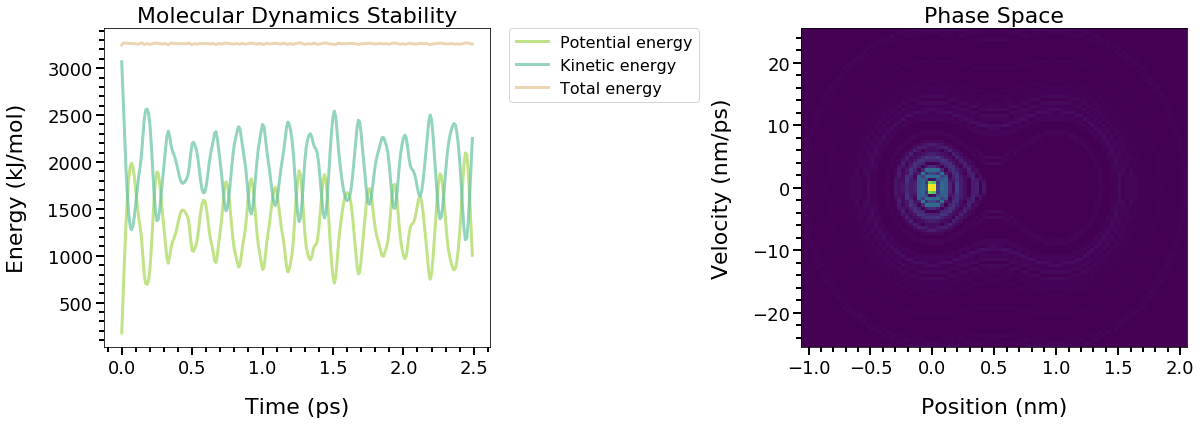

In [93]:
fig = plt.figure(figsize=(2*8.4,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

if case != 4:
    ax1.plot(Data_time[:250], np.sum(Data_Epot[:250], axis=1), color=colors[3], label=r'Potential energy', lw=3, alpha=0.7)
    ax1.plot(Data_time[:250], np.sum(Data_Ekin[:250], axis=1), color=colors[7], label=r'Kinetic energy', lw=3, alpha=0.7)
    ax1.plot(Data_time[:250], np.sum(Data_Etot[:250], axis=1), color=colors[1], label=r'Total energy', lw=3, alpha=0.7)
else:
    ax1.plot(Data_step[:250], Data_Epot[:250], color=colors[3], label=r'Potential energy', lw=3, alpha=0.7)

if case == 4:
    ax2.hist(Data_pos, density=True, bins=100)
else:
    #ax2.hist2d(Data_pos.T[0], Data_vel.T[0], normed=True, bins=100)
    ax2.hist2d(Data_pos.ravel(), Data_vel.ravel(), normed=True, bins=100)



# Graphics settings
for i,ax in enumerate([ax1, ax2]):
    ax.minorticks_on()
    ax.tick_params(axis='both',which='minor',length=5,width=2,labelsize=18)
    ax.tick_params(axis='both',which='major',length=8,width=2,labelsize=18)
    if i == 0:
        ax.legend(fontsize=16, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        if case == 4:
            ax.set_title(r'Monte Carlo Stability', fontsize=22)
            ax.set_xlabel(r'Step', fontsize=22, labelpad=20)
        else:
            ax.set_title(r'Molecular Dynamics Stability', fontsize=22)
            ax.set_xlabel(r'Time (ps)', fontsize=22, labelpad=20)
        ax.set_ylabel(r'Energy (kJ/mol)', fontsize=22, labelpad=20)
    elif i == 1:
        if case == 4:
            ax.set_title(r'Conformational Space',fontsize=22)
            ax.set_ylabel(r'Probability', fontsize=22, labelpad=20)
        else:
            ax.set_title(r'Phase Space', fontsize=22)
            ax.set_ylabel(r'Velocity (nm/ps)', fontsize=22, labelpad=20)
        ax.set_xlabel(r'Position (nm)', fontsize=22, labelpad=20)

plt.tight_layout()
plt.show()

### Program your self

In [ ]:
################################################
#                QUESTION 3.3                  #
# Boltzman distribution: Potential energy part #
################################################

plt.hist(Data_pos.ravel(), density=True, bins=1000)

# FINISH THE CODE: START
partition_function_PE = np.sqrt(np.pi/(2*(np.pi**2)*eps/(kB*Temperature)))

def probability_PE(m, Temperature, x):
    return np.exp(-eps*2.0*np.pi**2 * x**2 /(kB*Temperature) )/ partition_function_PE

# FINISH THE CODE: END

x = np.arange(-0.2, 0.2, 0.0001)
plt.plot(x, probability_PE(m, Temperature, x), 'r--', linewidth=3)
plt.xlabel(r'$\bf{x}\ \mathrm{(nm)}$')
plt.ylabel(r'$\bf{P(x)}$')
plt.show()

# Self-Check: Should always equal 1!
print('The area under the curve is equal to: {:03.2f}'.format(np.trapz(probability_PE(m,Temperature,x), x)))

In [ ]:
##############################################
#                QUESTION 3.3                #
# Boltzman distribution: Kinetic energy part #
##############################################
plt.hist(Data_vel.ravel(), density=True, bins=100)

# FINISH THE CODE: START
partition_function_KE = np.sqrt(2*np.pi/(m/(kB*Temperature)))

def probability_KE(m, Temperature, v):
    return np.exp(-0.5*m*v**2/(kB*Temperature)) / partition_function_KE

# FINISH THE CODE: END

v = np.arange(-5, 5, 0.001)
plt.plot(v, probability_KE(m, Temperature, v), 'r--', linewidth=3)
plt.xlabel(r'$\bf{v}\ \mathrm{(nm/ps)}$')
plt.ylabel(r'$\bf{P(v)}$')
plt.show()

# Self-Check: Should always equal 1!
print('The area under the curve is equal to: {:3.2f}'.format(np.trapz(probability_KE(m,Temperature,v), v)))

In [ ]:
x = np.arange(-0.5, 1.5, 0.01)
energy = []
for i in x:
    u, f = Potential(i)
    energy.append(u)

plt.plot(x,energy)

In [ ]:
plt.plot(Data_time[:250], Data_Temp[:250])
print(np.array(Data_Temp).mean())

In [ ]:
x = np.asarray([[1,1,1], [2,2,2], [3,3,3]])

b = np.asarray([9,9,9])

x[0] = b
x

In [ ]:
Data_Temp.max()
Data_Temp.min()

In [ ]:
plt.plot(Data_time, Data_vel[:,2])